In [2]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.tum_vie as tum_dset

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
#define time range
t_start = 17.52
duration = 0.2
t_end = t_start + duration
shape_orig = (720, 1280)

In [4]:
events_raw = tum_dset.load_events_time(path + "data/tum-vie/mocap-1d-trans-events_right.h5", t_start, t_end)

C:\Users/schiavaz/lava-nc/depth\events_utils\tum_vie.py:38: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  events_h5 = h5py.File(f)["events"]
C:\Users/schiavaz/lava-nc/depth\events_utils\tum_vie.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  events_h5 = h5py.File(f)["events"]


5818422 events


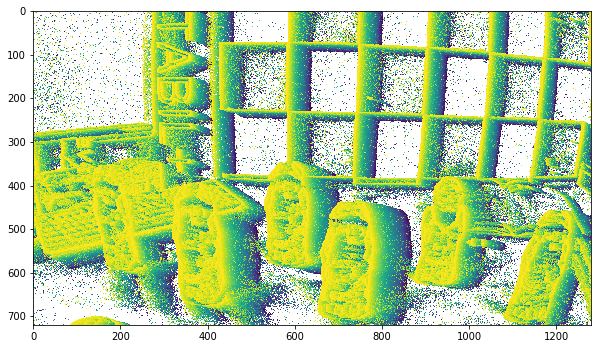

In [5]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_raw, shape_orig, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

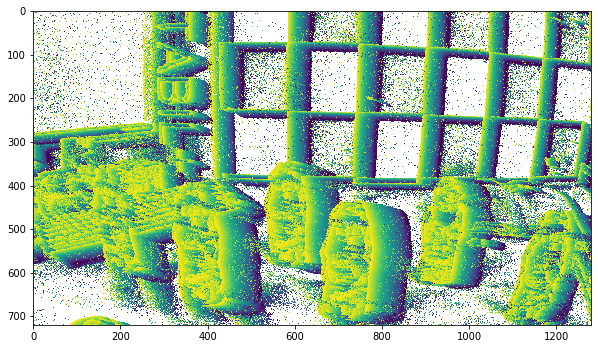

In [6]:
events_ref = flt.filter_refract(events_raw, 0.5)
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_ref, shape_orig, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

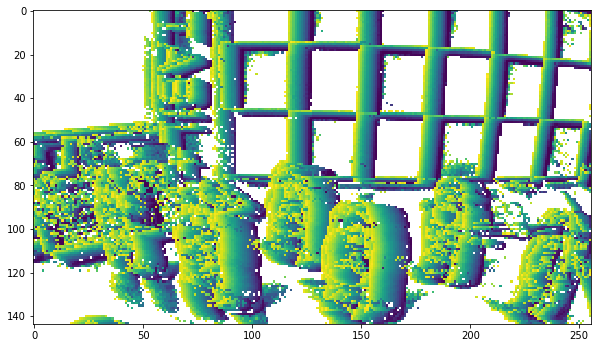

In [24]:
events, shape = flt.filter_conv(events_ref, shape_orig, factor=5, thresh=0.5)
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [25]:
# events = flt.filter_refract(events, 0.1)

In [26]:
poses = tum_dset.load_poses(path + "data/tum-vie/mocap-1d-trans-vi_gt_data/mocap_data.txt")
k = np.ones(100)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")

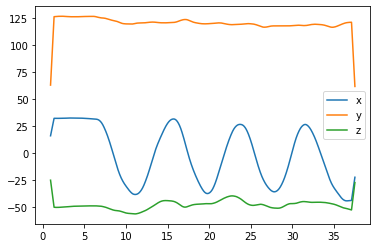

In [27]:
plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
plt.legend()

In [28]:
time_d = td2d.TimeDifference2d(shape, events, poses, 1051.3170714099033)

(2, 4386)


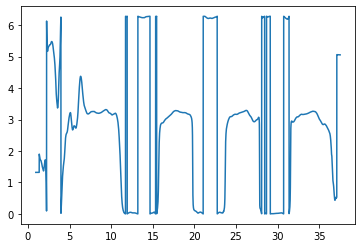

In [29]:
# test = time_d.directions
# test_c = np.convolve(test[:,1], np.ones(500), mode="same")
# plt.plot(test_c)
# time_d.directions[:,1] = test_c
test = np.mod(time_d.directions[:,1], 2*np.pi)
plt.plot(time_d.directions[:,0], test)
time_d.directions[:,1] = test

In [30]:
U, V, std_u, std_v = td2d.measure_td2(events, shape, dist=1, px_range_pred=5, std_thr=1.1, mean_thr=0.005, start_delay=0.03, final_delay=0.05)

100%|█████████████████████████████████████████████████████████████████████████| 44599/44599 [00:01<00:00, 25440.16it/s]


In [31]:
%matplotlib inline
plt.figure(figsize=(30, 30))
final_td_m = np.ma.masked_where(final_td == 0, final_td)
m = plt.imshow(final_td_m, cmap="jet_r", interpolation="none")
#plt.colorbar(m)

NameError: name 'final_td' is not defined

<Figure size 2160x2160 with 0 Axes>

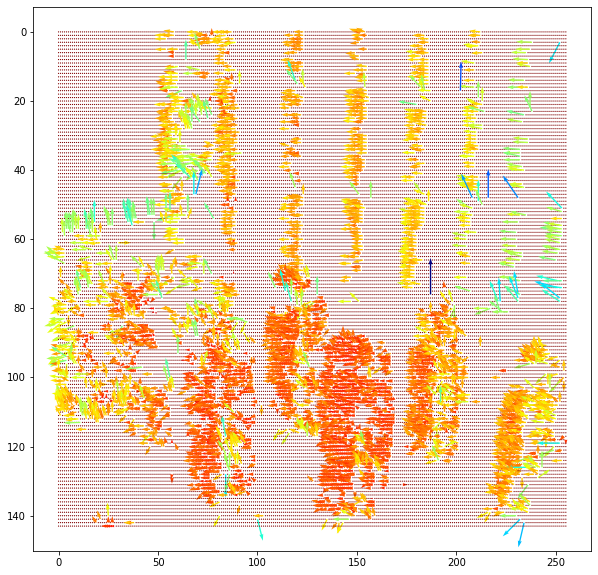

In [32]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = np.sqrt(U**2 + V**2)
plt.quiver(U, V, m, scale =1, cmap="jet_r")
plt.gca().invert_yaxis()

In [19]:
ang_flow_u, ang_flow_v = time_d.get_angular_flow(t_start)

[0.05833012 0.02428401 0.02247798]


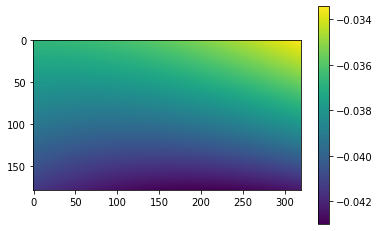

In [20]:
m = plt.imshow(ang_flow_u)
plt.colorbar(m)

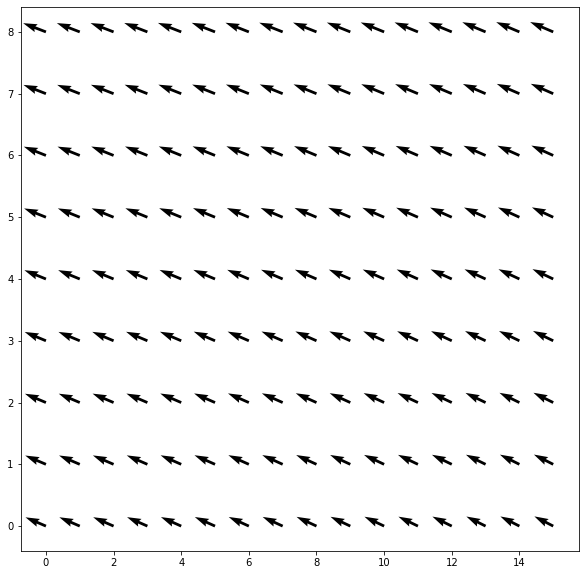

In [21]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(ang_flow_u[::20, ::20], ang_flow_v[::20, ::20], scale =1, cmap="jet_r")

In [22]:
u = np.divide(1.0, final_td_m, where=final_td!=0.0)
d = td.v2depth(u, 2.0, 200.0)

NameError: name 'final_td_m' is not defined

In [23]:
plt.figure(figsize=(10, 10))
#plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(d, cmap="jet_r", interpolation="none")
#plt.colorbar(m)

NameError: name 'd' is not defined

<Figure size 720x720 with 0 Axes>

In [67]:
%matplotlib qt
vis.visualize3d(d, range=(2, 8))

In [146]:
poses = tum_dset.load_poses(path + "data/tum-vie/mocap-1d-trans-vi_gt_data/mocap_data.txt")
k = np.ones(10)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")
poses[:,4] = np.convolve(poses[:,4], k, mode="same")
poses[:,5] = np.convolve(poses[:,5], k, mode="same")
poses[:,6] = np.convolve(poses[:,6], k, mode="same")
poses[:,7] = np.convolve(poses[:,7], k, mode="same")

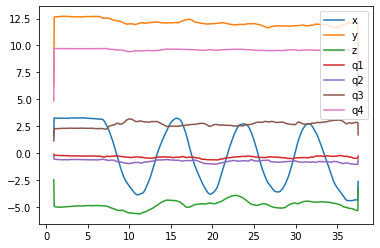

In [147]:
plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
plt.plot(poses[:,0], poses[:,4], label="q1")
plt.plot(poses[:,0], poses[:,5], label="q2")
plt.plot(poses[:,0], poses[:,6], label="q3")
plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [148]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx+1]

In [149]:
pose1

array([17.52599676, -0.26108175, 12.36192572, -4.90331119, -0.37367028,
       -0.67460962,  2.6733211 ,  9.60513169])

In [150]:
pose2

array([17.53433076, -0.28442916, 12.35881829, -4.90036124, -0.3715489 ,
       -0.67302427,  2.67445222,  9.60501003])

In [151]:
vel = (pose2[1:] - pose1[1:]) / (pose2[0] - pose1[0])

In [152]:
ang = vel[3:]

In [153]:
ang

array([ 0.25454541,  0.19022761,  0.13572322, -0.0145972 ])

In [154]:
from scipy.spatial.transform import Rotation as R
r = R.from_quat(ang)

In [155]:
r.as_rotvec()

array([-2.25205627, -1.68301317, -1.20079295])

In [156]:
r.as_euler("xyz")

array([ 2.64892183, -0.67395847,  1.45929876])